# Compute ADU counts over time

Use inferred buildings for 2016, 2018 and 2020 to compute small building growth.

## 0. Set up

In [ ]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds

In [18]:
import json
import geopandas as gpd
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pyproj
import rasterio
import rasterio.features
import rasterio.plot
import shapely
from shapely.geometry import box, Polygon
from tqdm import tqdm

tqdm.pandas()

In [19]:
def visualize_tile_full_year(fn, year):
    tile_bounds = get_bounds(tile_bounds_dict_all[year], fn)
    osm_tile = gpd.clip(building_footprints_osm, tile_bounds)
    infer_tile = gpd.clip(building_footprints_infer[year], tile_bounds)
    zone_tile = gpd.clip(zoning, tile_bounds)

    raster = rasterio.open(os.path.join(TIF_FP[year], '{}.tif'.format(fn)))

    plt.clf()
    fig, ax = plt.subplots(figsize=(4, 4))
    rasterio.plot.show(raster, ax=ax,)
    zone_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='black', alpha=0.5)
    osm_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='blue')
    infer_tile.to_crs('EPSG:26910').plot(ax=ax, facecolor='red', alpha=0.5)
    plt.show()

## 1. Load data / Paths

In [20]:
# Paths
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
TIF_FP = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/raw_tif', 
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/raw_tif',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
}

INFERENCES_DIR = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2016/infer',
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/2018/infer',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'
}
NAIP_TIF = {
    '2016': '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2016',
    '2018': '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2018',
    '2020': '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2020',
}

YEARS = ['2016', '2018', '2020']

In [21]:
# Load tile dict for each year
tile_bounds_dict_all = {}
for year in ['2016', '2018', '2020']:
    OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}'.format(year))
    with open(os.path.join(OUTPUT_FP, 'tile_bounds.json'), "r") as f:
        tile_bounds_dict = json.load(f)
        tile_bounds_dict_all[year] = tile_bounds_dict

In [ ]:
# Load inference files for 2016, 2018, 2020
building_footprints_infer20 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2020/inference_building_processed')
building_footprints_infer16 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2016/inference_building_processed')
building_footprints_infer18 = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2018/inference_building_processed')

# Load SJ shapefiles, zoning data and OSM data
cbg_sj, zoning = load_data(shapefile_fp=SHAPEFILE_FP, oak_fp=OAK_FP)
building_footprints_osm = gpd.read_file('/oak/stanford/groups/deho/building_compliance/outputs/cbg-inference-2020/osm_building_processed')

In [ ]:
# Consolidate inferred buildings for all years and limit to small buildings
building_footprints_infer = {
    '2016': building_footprints_infer16,
    '2018': building_footprints_infer18,
    '2020': building_footprints_infer20
}

small_bfi = gpd.GeoDataFrame()
for year, gdf in building_footprints_infer.items():
    gdf['year'] = year
    small_bfi = pd.concat([small_bfi, gdf])
small_bfi = small_bfi.loc[small_bfi['small'] == 1]

In [ ]:
# Get tiles for all years
tiles_gdf = {}
for year in YEARS:
    tiles = glob.glob(os.path.join(INFERENCES_DIR[year], '*.npy'))
    tiles = [t.split(os.path.sep)[-1].replace('.npy', '') for t in tiles]
    tile_metrics_pd = pd.DataFrame(tiles, columns=['file'])

    tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
        lambda name: get_bounds(tile_bounds_dict_all[year], name) if name in list(tile_bounds_dict_all[year].keys()) else None
    )
    tiles_gdf[year] = gpd.GeoDataFrame(tile_metrics_pd.copy(), crs='EPSG:4326')

<Figure size 640x480 with 0 Axes>

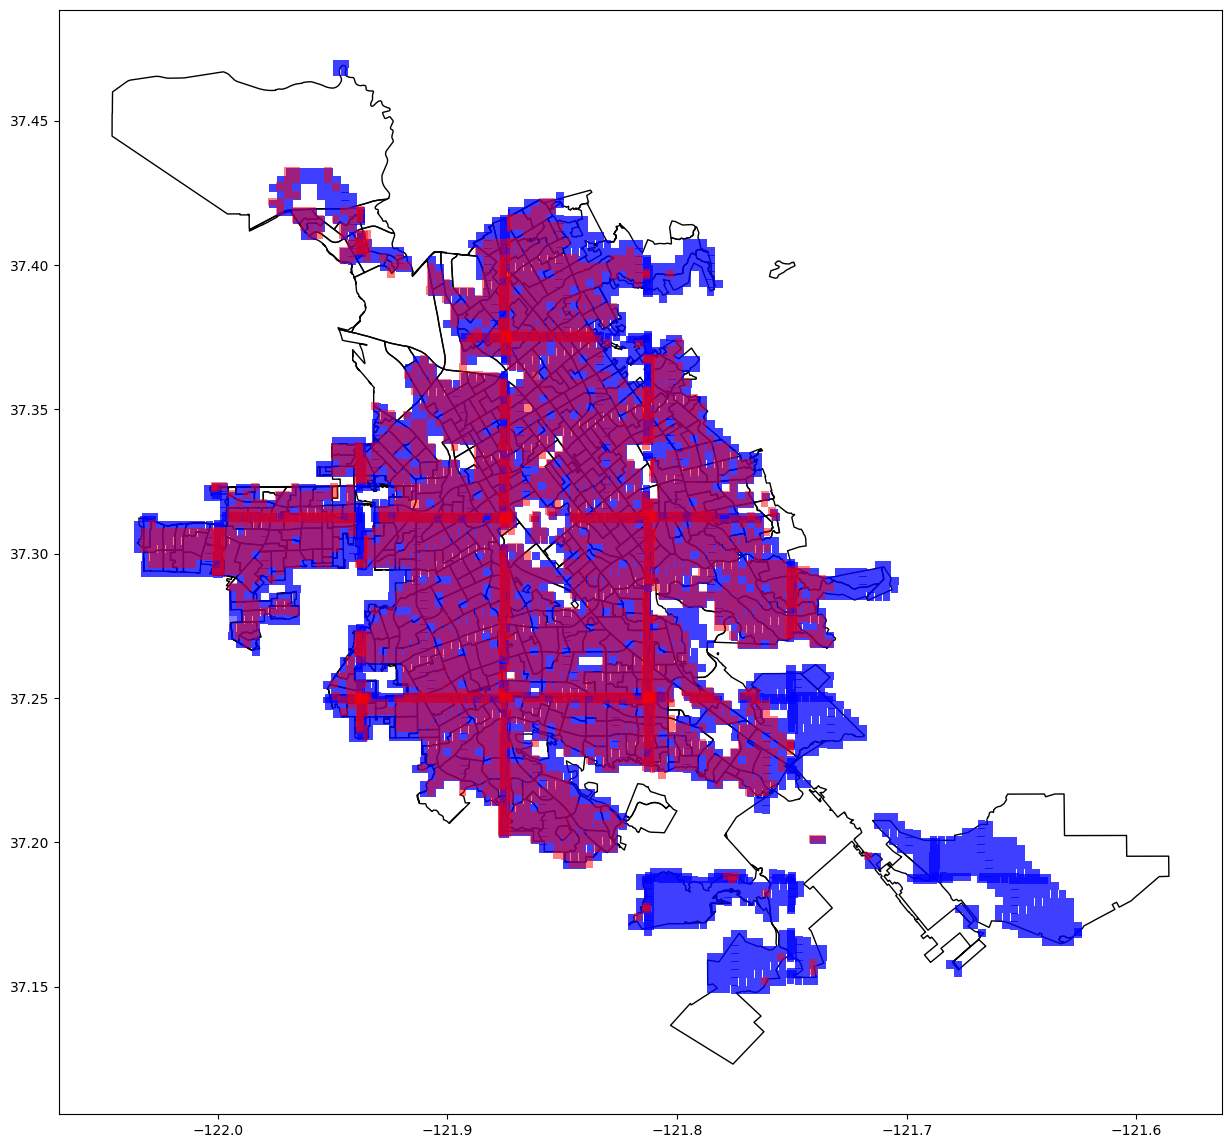

In [8]:
# Visualize all tiles
colors = {'2016': 'blue', '2018': 'blue', '2020': 'red'}

plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
for year in ['2016', '2018', '2020']:
    tiles_gdf[year].plot(ax=ax, facecolor=colors[year], alpha=0.5)
plt.show()

In [ ]:
# Generate shp of tile intersection for all years
tile_intersection = (
    tiles_gdf['2016'].geometry.unary_union).intersection(
    tiles_gdf['2018'].geometry.unary_union).intersection(
    tiles_gdf['2020'].geometry.unary_union
)

# Check
gpd.GeoDataFrame(geometry=[tile_intersection]).plot()
plt.show()

## 2. Tile checks

Check 2016, 2018, 2020 tiles

Year: 2016


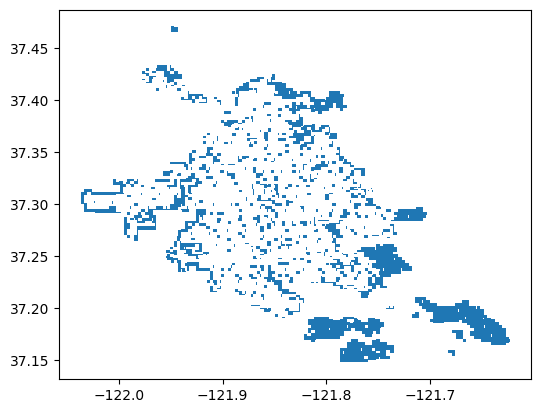

Inferred small building area in additional tiles: 
621449.0
Number of inferred small buildings in additional tiles: 
12834
Percentage of inferred small building area in additional tiles vs all tiles
16.08
Percentage of inferred small buildings in additional tiles vs all tiles
15.6
OSM Small build area in additional tiles: 
360373.95
OSM Number of small buildings in additional tiles: 
6410


Year: 2018


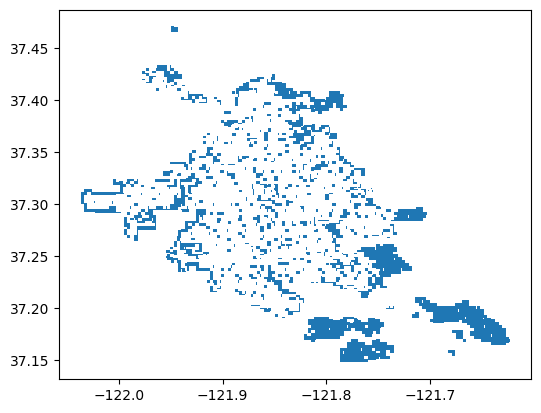

Inferred small building area in additional tiles: 
653999.0
Number of inferred small buildings in additional tiles: 
14931
Percentage of inferred small building area in additional tiles vs all tiles
15.97
Percentage of inferred small buildings in additional tiles vs all tiles
15.62
OSM Small build area in additional tiles: 
360639.41
OSM Number of small buildings in additional tiles: 
6414




In [10]:
# Check num buildings for tiles in 2016,18 not covered by 2020 tiles
for year in ['2016', '2018']:
    print('Year: {}'.format(year))
    tiles_year_ex20 = (tiles_gdf[year].geometry.unary_union).difference(tiles_gdf['2020'].geometry.unary_union)

    gpd.GeoDataFrame(geometry=[tiles_year_ex20]).plot()
    plt.show()
    
    test = gpd.clip(building_footprints_infer[year], tiles_year_ex20)

    print('Inferred small building area in additional tiles: ')
    print(round(test.loc[test['small'] == 1]['area'].sum(), 0))

    print('Number of inferred small buildings in additional tiles: ')
    print(test.loc[test['small'] == 1]['area'].count())

    print('Percentage of inferred small building area in additional tiles vs all tiles')
    print(round(test.loc[test['small'] == 1]['area'].sum() / (building_footprints_infer[year].loc[building_footprints_infer[year]['small'] == 1]['area'].sum()) * 100, 2))

    print('Percentage of inferred small buildings in additional tiles vs all tiles')
    print(round(test.loc[test['small'] == 1]['area'].count() / (building_footprints_infer[year].loc[building_footprints_infer[year]['small'] == 1]['area'].count()) * 100, 2))
    
    # Check OSM builds in this space
    osm_ext = gpd.clip(building_footprints_osm, tiles_year_ex20)
    
    print('OSM Small build area in additional tiles: ')
    print(round(osm_ext.loc[osm_ext['small'] == 1]['area'].sum(), 2))

    print('OSM Number of small buildings in additional tiles: ')
    print(osm_ext.loc[osm_ext['small'] == 1]['area'].count())
    
    print('\n')

Use raw tifs for 2020

In [11]:
# Get tile bounds dict
tile_bounds_dict_all['2020-raw'] = {}
for tif in tqdm(glob.glob(os.path.join(TIF_FP['2020'], '*.tif'))):
    file_name = tif.split(os.path.sep)[-1].replace('.tif', '')
    with rasterio.open(tif) as inds:
        bounds = inds.bounds
        geom = box(*bounds)

    # prepare to convert TIF bounds to standard 4326
    wgs84 = pyproj.CRS('EPSG:26910') # LA is 11, SJ is 10
    utm = pyproj.CRS('EPSG:4326')
    project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

    # Convert
    utm_geom = shapely.ops.transform(project, geom)
    tile_bounds_dict_all['2020-raw'][file_name] = list(utm_geom.exterior.coords)

100%|██████████| 4736/4736 [08:47<00:00,  8.97it/s]


In [12]:
# Get gpd and add to tiles_gdf dict
tiles = list(tile_bounds_dict_all['2020-raw'].keys())
tile_metrics_pd = pd.DataFrame(tiles, columns=['file'])

tile_metrics_pd['geometry'] = tile_metrics_pd.file.progress_apply(
    lambda name: get_bounds(tile_bounds_dict_all['2020-raw'], name))
tiles_gdf['2020-raw'] = gpd.GeoDataFrame(tile_metrics_pd.copy(), crs='EPSG:4326')

100%|██████████| 4736/4736 [00:00<00:00, 45728.80it/s]


<Figure size 640x480 with 0 Axes>

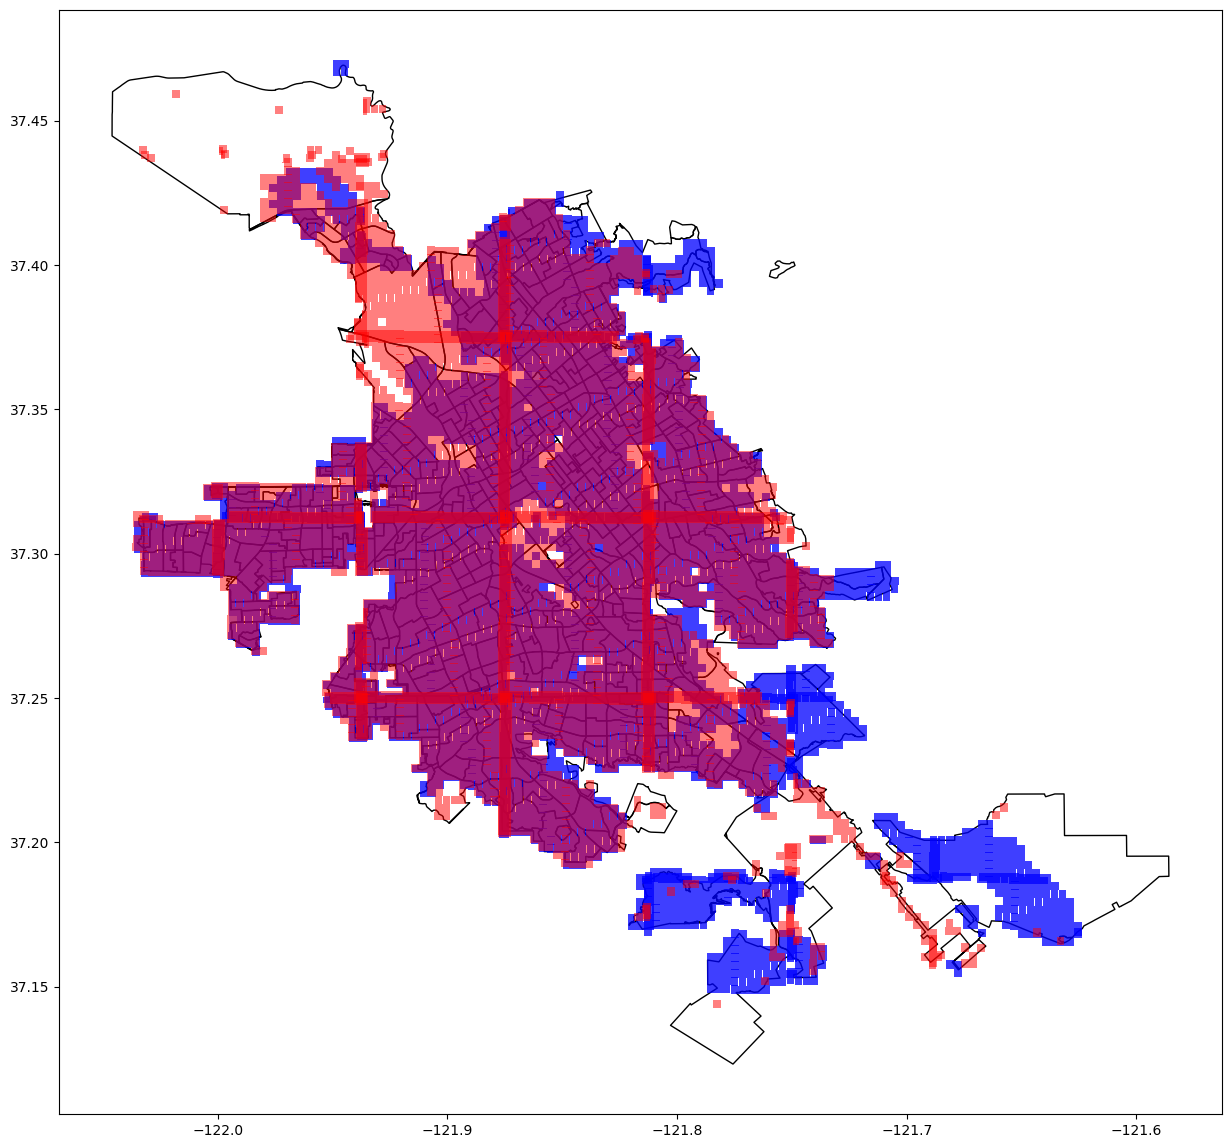

In [13]:
# Visualize all tiles
colors = {'2016': 'blue', '2018': 'blue', '2020': 'red'}

plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
for year in ['2016', '2018']:
    tiles_gdf[year].plot(ax=ax, facecolor=colors[year], alpha=0.5)
tiles_gdf['2020-raw'].plot(ax=ax, facecolor='red', alpha=0.5)
plt.show()

In [14]:
for key in tile_bounds_dict_all.keys():
    print('Year: {}; Number of tiles: {}'.format(key, len(tile_bounds_dict_all[key].keys())))

Year: 2016; Number of tiles: 4648
Year: 2018; Number of tiles: 4648
Year: 2020; Number of tiles: 3074
Year: 2020-raw; Number of tiles: 4736


Check tiles against original NAIP tiles

In [24]:
with open(os.path.join(NAIP_TIF['2020'], 'bounds.p'), 'rb') as f:
    p = pickle.load(f)

In [27]:
naip_gpd = gpd.GeoDataFrame(geometry=list(p.values()), crs='EPSG:4326')

<Figure size 640x480 with 0 Axes>

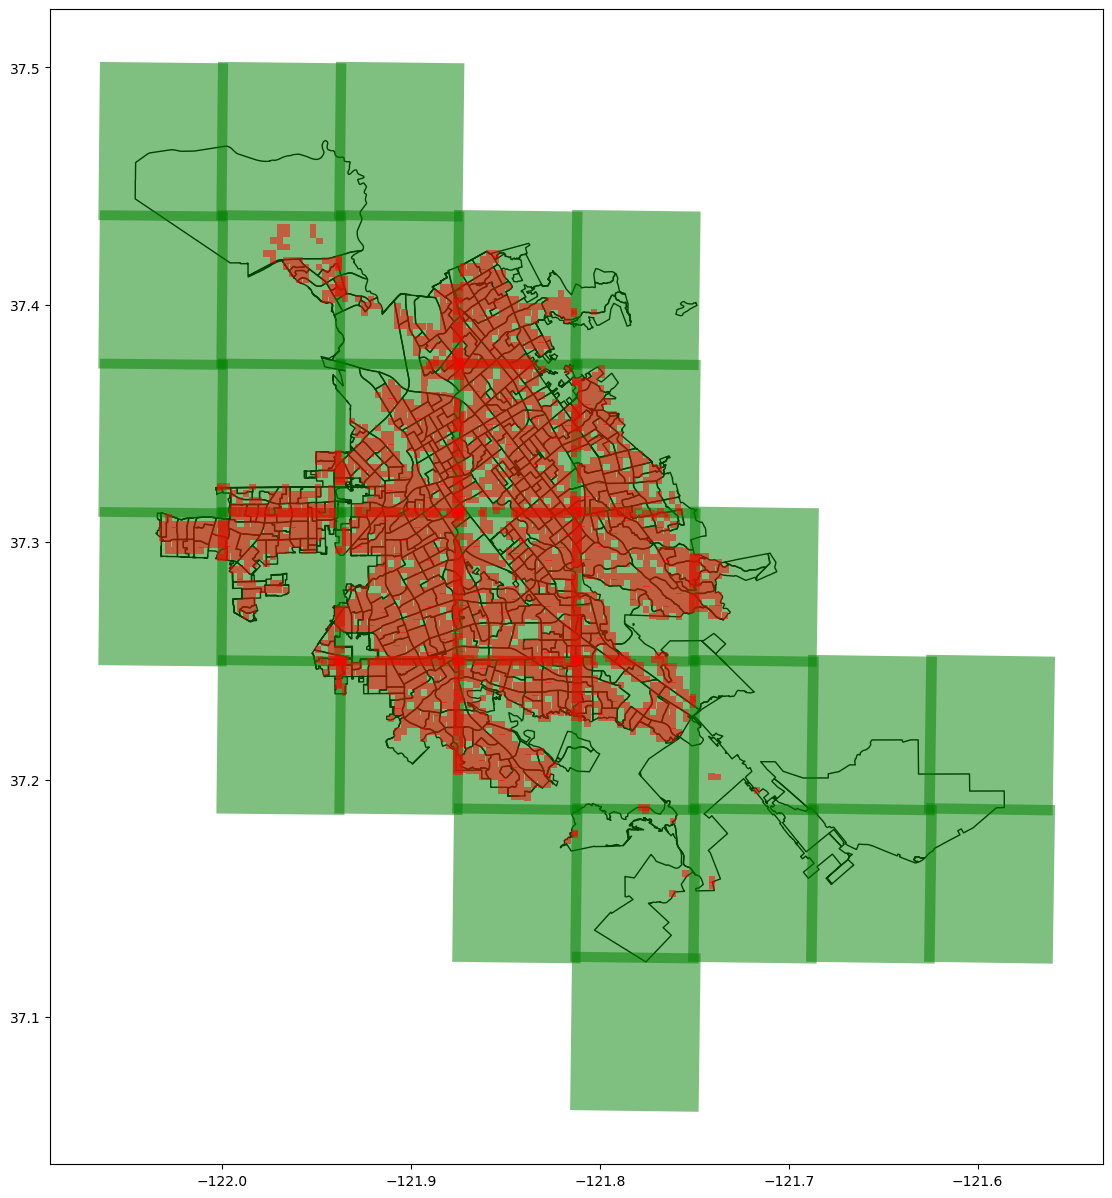

In [30]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 15))
cbg_sj.plot(ax=ax, facecolor='none', edgecolor='black')
tiles_gdf['2020'].plot(ax=ax, facecolor='red', zorder=2, alpha=0.5)
naip_gpd.plot(ax=ax, facecolor='green', zorder=1, alpha=0.5)
plt.show()

## 3. Raw inferences

### 3.1 Over all tiles

In [15]:
# Number of tiles for each year
for year in YEARS:
    print('Year: {}; Num tiles: {}'.format(year, len(list(tile_bounds_dict_all[year].keys()))))

Year: 2016; Num tiles: 4648
Year: 2018; Num tiles: 4648
Year: 2020; Num tiles: 3074


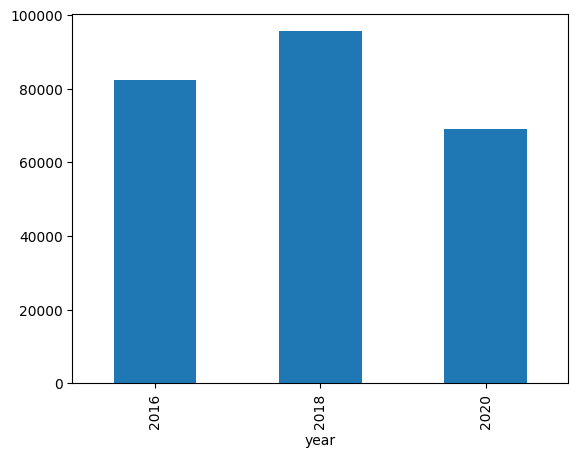

In [16]:
# Trends in raw small building counts
n_small_ts = small_bfi.groupby('year')['GEOID'].count()
n_small_ts.plot.bar()
plt.show()

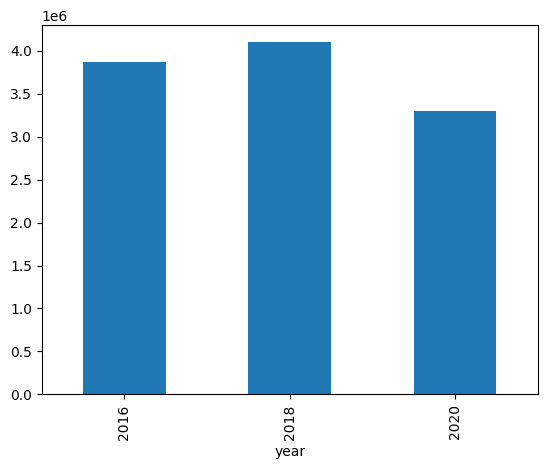

In [17]:
# Trends in raw small building area
a_small_ts = small_bfi.groupby('year')['area'].sum()
a_small_ts.plot.bar()
plt.show()

### 3.2 Over intersecting tiles for all 3 years

In [ ]:
# Limit inferences to areas with tile overlap across all years
building_footprints_infer_clipped = {}
for year, gdf in building_footprints_infer.items():
    print(year)
    temp_file = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'Error-Analysis', 'temp', 'bfi_small_clipped_{}'.format(year))
    if not os.path.exists(temp_file):
        temp = gpd.clip(gdf.loc[gdf['small']==1], tile_intersection)
        print(len(temp))
        temp = temp.geometry.explode(index_parts=True)
        temp = gpd.GeoDataFrame(geometry=temp)
        print(len(temp))
        temp = temp[temp.geom_type.isin(['Polygon', 'MultiPolygon'])]
        print(len(temp))
        temp.to_file(temp_file)
    building_footprints_infer_clipped[year] = gpd.read_file(temp_file)

In [ ]:
# Check
building_footprints_infer_clipped['2016'].plot()
plt.show()

In [ ]:
small_bfi_clipped = gpd.GeoDataFrame()
for year, gdf in building_footprints_infer_clipped.items():
    gdf['year'] = year
    small_bfi_clipped = pd.concat([small_bfi_clipped, gdf])

In [13]:
small_bfi_clipped.head()

,level_0,level_1,geometry,year
0,15790,0,"POLYGON ((-121.76174 37.29496, -121.76174 37.2...",2016
1,15791,0,"POLYGON ((-121.76198 37.29496, -121.76198 37.2...",2016
2,16149,0,"POLYGON ((-121.75323 37.29496, -121.75323 37.2...",2016
3,16617,0,"POLYGON ((-121.76005 37.29505, -121.76005 37.2...",2016
4,16233,0,"POLYGON ((-121.75705 37.29508, -121.75705 37.2...",2016


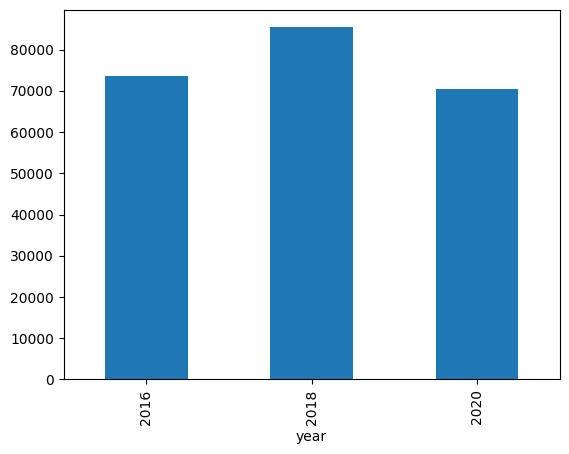

In [14]:
# Trends in raw small building counts
n_small_ts_clipped = small_bfi_clipped.groupby('year')['level_0'].count()
n_small_ts_clipped.plot.bar()
plt.show()

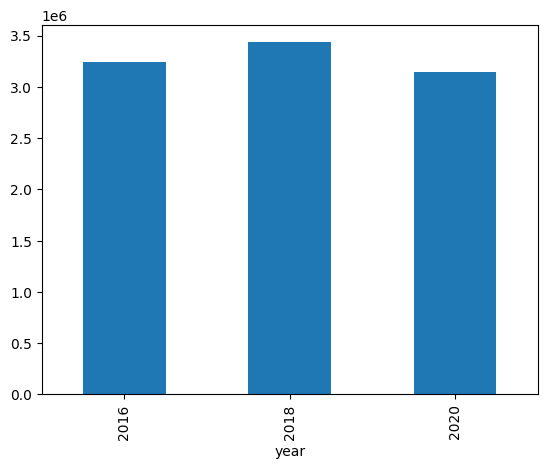

In [17]:
# Trends in raw small building area
small_bfi_clipped = small_bfi_clipped.to_crs('EPSG:26910')
small_bfi_clipped['area'] = small_bfi_clipped.area
small_bfi_clipped = small_bfi_clipped.to_crs('EPSG:4326')
a_small_ts_clipped = small_bfi_clipped.groupby('year')['area'].sum()
a_small_ts_clipped.plot.bar()
plt.show()

In [ ]:
# Visualize tiles
#visualize_tile_full_year('m_3712149_ne_10_060_20200525_358', '2020')
#visualize_tile_full_year('m_3712149_ne_10_h_20160529_216', '2016')

Understand drop in 2020 numbers